## Importar Librerias

In [1]:
# Importación de las librerías necesarias
import numpy as np
import pandas as pd
# Puede que nos sirvan también
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.preprocessing import StandardScaler, Normalizer, RobustScaler, MinMaxScaler
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression, Perceptron, Ridge, Lasso
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error, classification_report
from sklearn.metrics import roc_curve, auc, r2_score, mean_absolute_error
from sklearn.linear_model import SGDClassifier, LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

np.random.seed(0)  # Para mayor determinismo

## 1.Carga de datos

Al final del practico anterior obtuvimos un dataset enriquesido con features georeferenciadas. Es el momento de utilizarlo.

Exporta el dataframe obtenido en el ultimo practico a un csv y cargalo como dataframe.

In [2]:
untrd = pd.read_csv('untrd.csv')

In [3]:
untrd.head()

,COD_ID,DIST,PAC_1,PAC_2,PAC_3,FAS_CON_P,FAS_CON_S,FAS_CON_T,SIT_ATIV,TIP_UNID,...,g_eigenvec,g_clustering,dist_to_trs,COMP,R,X,CNOM,CMAX,z_mod,z_ang
0,4_1040341,46,452971,ET4_1040341,0,ABC,ABCN,0,AT,38,...,5.680527e-06,0.0,8170.23,8170.23,10.595753,3.850102,1.436459,2.052084,11.273564,0.348529
1,4_1040306,46,452681,ET4_1040306,0,ABC,ABCN,0,AT,38,...,2.625699e-06,0.0,10274.81,10274.81,13.859956,4.858406,1.280666,1.829523,14.686814,0.337152
2,4_1040035,46,462831,ET4_1040035,ET4_1040035,AB,AN,BN,AT,38,...,4.072908e-07,0.0,15507.34,15507.34,11.510700,6.914966,2.466445,3.523493,13.428066,0.540965
3,4_1040036,46,465251,ET4_1040036,ET4_1040036,AB,AN,BN,AT,38,...,7.984421e-07,0.0,18841.79,18841.79,10.493560,8.267169,2.344369,3.349098,13.358925,0.667278
4,4_1040038,46,464061,ET4_1040038,ET4_1040038,AB,AN,BN,AT,38,...,3.746185e-07,0.0,20346.48,20346.48,12.827334,8.988066,2.293335,3.276193,15.662880,0.611193


In [4]:
print(untrd.columns)

Index(['COD_ID', 'DIST', 'PAC_1', 'PAC_2', 'PAC_3', 'FAS_CON_P', 'FAS_CON_S',
       'FAS_CON_T', 'SIT_ATIV', 'TIP_UNID',
       ...
       'g_eigenvec', 'g_clustering', 'dist_to_trs', 'COMP', 'R', 'X', 'CNOM',
       'CMAX', 'z_mod', 'z_ang'],
      dtype='object', length=166)


Ahora debemos eliminar variables que no aporte informacion por ejemplo:


*   Indices y IDs
*   Referencias a otras tablas
*   Variables compuestas (listas, jsons, geometrias)

Identifica las variables que cumplen este criterio y eliminelas del dataset. Retira tambien la variable de salida que no van a utilizar FIC o DIC.



In [5]:
columns_not_int = ['COD_ID', 'DIST', 'PAC_1', 'PAC_2', 'PAC_3', 'FAS_CON_P', 'FAS_CON_S', 
                   'FAS_CON_T', 'TIP_UNID', 'POS', 'ATRB_PER', 'CAP_ELO', 'CAP_CHA', 'CONF',
                   'POSTO', 'DAT_CON', 'CTMT', 'UNI_TR_S', 'SUB', 'CONJ', 'MUN', 'BANC', 'ENDNODE','NODE',
                   'MRT', 'DESCR', 'geometry']

In [6]:
untrd_limpio = untrd.drop(columns_not_int, axis=1)

In [7]:
untrd_limpio.describe(include='O').T

,count,unique,top,freq
SIT_ATIV,10504,2,AT,10239
TIP_TRAFO,10504,2,MT,6757
ARE_LOC,10504,2,NU,8714
ARE_LOC_moda,8258,4,NU,6822
GRU_TAR_moda,8258,12,B1,6750
CLAS_SUB_moda,8258,85,RE1,6016
CNAE_moda,8258,33,0,8209


In [8]:
#untrd_limpio.drop('ARE_LOC', axis=1, inplace=True)

In [9]:
untrd_limpio = pd.get_dummies(untrd_limpio, columns=['ARE_LOC', 'ARE_LOC_moda', 'GRU_TAR_moda', 'CLAS_SUB_moda',
                                                    'CNAE_moda', 'TIP_TRAFO', 'SIT_ATIV'], dummy_na=True)

In [10]:
filter_std = [col for col in untrd_limpio.columns if col.endswith('std')]
untrd_limpio.drop(filter_std, axis=1, inplace=True)

In [11]:
untrd_limpio.shape

(10504, 266)

In [12]:
columns = untrd_limpio.columns
nanes = {}

for col in columns:
    nanes.update({col:untrd_limpio[col].isna().sum()})
    
#nanes

In [13]:
untrd_limpio.dropna(inplace=True)

In [14]:
untrd_limpio.to_csv('untrd_procesado.csv', index=False)

In [15]:
y = untrd_limpio.FIC_media

In [16]:
filter_FIC = [col for col in untrd_limpio.columns if col.startswith('FIC')]
untrd_limpio.drop(filter_FIC, axis=1, inplace=True)

In [17]:
untrd_limpio.shape

(8258, 260)

## 2. Preprosecamiento y particion de datos

Siempre se recomienda partir los datos antes de realizar el preprocesamiento, y guardar el pipeline de transformacion para aplicar en operaciones futuras.

Sin embargo algunas operaciones principalmente la codificacion de variables puede realizarse antes de hacer la particion ya que no representa una interaccion entre las filas.

Genere una particion de datos en sets de entrenamiento y validacion.

In [18]:
X_train, X_valid, y_train, y_valid = train_test_split(untrd_limpio, y, 
                                                      test_size=0.2, random_state=0)

In [19]:
X_train.shape, X_valid.shape

((6606, 260), (1652, 260))

Un elemento que tenemos que siempre debemos tener en cuenta es que el procesamiento que debemos hacer sobre los datos esta relacionado con el algoritmo que vayas a implementar.

## 3. Preparacion de datos para regresion lineal

Los algoritmos de regresion solo aceptan entradas numericas, por lo tanto el primer paso que debemos realizar es codificar las variables categoricas numericamente.

Adicionalmente las diferencias en las dimensiones absolutas de las variables van a tener un impacto muy pronunciado en los coeficientes calculados por lo que tambien se recomienda realizar la normalizacion de las variables. 

Esto puede hacerse de varias maneras:

*   Media/Mediana y desviacion standard
*   Minimo y Maximo (Cuidado con los outliers)
*   De 1 a -1

Implemente una funcion o pipeline que aplique codificacion de variables categoricas y luego normalizacion. Recuerde que los parametros de normalizacion se calculan usando unicamente los valores de entrenamiento.

In [20]:
procesos = [StandardScaler(), Normalizer(), RobustScaler(), MinMaxScaler()]

## 4. Regresion lineal simple y regularizada.

Con los datos preprocesados obtenidos en el punto anterior implemente una regresion lineal. 

In [21]:
from sklearn.pipeline import make_pipeline

In [22]:
for proceso in procesos:
    lineal_model = make_pipeline(proceso, LinearRegression())
    lineal_model.fit(X_train, y_train)
    y_train_pred = lineal_model.predict(X_train)
    y_valid_pred = lineal_model.predict(X_valid)
    print('R2_train: ', r2_score(y_train,y_train_pred))
    print('MAE: ', mean_absolute_error(y_train,y_train_pred))
    print('MSE: ', mean_squared_error(y_train,y_train_pred))
    print('R2_valid: ', r2_score(y_valid,y_valid_pred))
    print('MAE: ', mean_absolute_error(y_valid,y_valid_pred))
    print('MSE: ', mean_squared_error(y_valid,y_valid_pred))

R2_train:  0.5125637826032553
MAE:  2.4954361876824933
MSE:  10.294654723547069
R2_valid:  -3.105776240338655e+21
MAE:  8630742535.629868
MSE:  6.780223437695933e+22
R2_train:  0.5143134732831043
MAE:  2.4902245629481623
MSE:  10.257701249883885
R2_valid:  -21005.73310938096
MAE:  36.74261168687788
MSE:  458598.2155691849
R2_train:  0.5125638192090517
MAE:  2.4954211089549183
MSE:  10.294653950432513
R2_valid:  -42359169393261.81
MAE:  1127468.876453989
MSE:  924743480844633.6
R2_train:  0.5125641842785295
MAE:  2.495398570794258
MSE:  10.294646240163786
R2_valid:  -6.932593760673326e+17
MAE:  139803793.77891073
MSE:  1.5134552866247852e+19


In [23]:
for proceso in procesos:
    lineal_model = make_pipeline(proceso, Ridge())
    lineal_model.fit(X_train, y_train)
    y_train_pred = lineal_model.predict(X_train)
    y_valid_pred = lineal_model.predict(X_valid)
    print('R2_train: ', r2_score(y_train,y_train_pred))
    print('MAE: ', mean_absolute_error(y_train,y_train_pred))
    print('MSE: ', mean_squared_error(y_train,y_train_pred))
    print('R2_valid: ', r2_score(y_valid,y_valid_pred))
    print('MAE: ', mean_absolute_error(y_valid,y_valid_pred))
    print('MSE: ', mean_squared_error(y_valid,y_valid_pred))

R2_train:  0.5113581168427426
MAE:  2.4995582096187583
MSE:  10.320118388891368
R2_valid:  0.4112473063916806
MAE:  2.7312528008504273
MSE:  12.853066361839588
R2_train:  0.030380373926514048
MAE:  3.5778671738823435
MSE:  20.47837010739945
R2_valid:  0.027787125801395196
MAE:  3.620482074825348
MSE:  21.2243896725552
R2_train:  0.5099071520327074
MAE:  2.5132423532278523
MSE:  10.350762771073523
R2_valid:  0.40138484838769695
MAE:  2.738609990201904
MSE:  13.068373788187246
R2_train:  0.48259743578160896
MAE:  2.56977235450764
MSE:  10.92754407982528
R2_valid:  0.43124972245423066
MAE:  2.741054330442931
MSE:  12.416393402479647


In [24]:
lineal_model = LinearRegression()
lineal_model_ridge = make_pipeline(MinMaxScaler(), Ridge())

### Evaluacion del modelo

Para evaluar el modelo calcule R cuadrado, error medio absoluto y error medio cuadrado. Tanto de entrenamiento como de validacion.

In [25]:
lineal_model.fit(X_train, y_train)
lineal_model_ridge.fit(X_train, y_train);

In [26]:
y_train_pred = lineal_model.predict(X_train)
y_valid_pred = lineal_model.predict(X_valid)

In [27]:
print('Conjunto de entrenamiento: modelo lineal simple')
print('R2: ', r2_score(y_train,y_train_pred))
print('MAE: ', mean_absolute_error(y_train,y_train_pred))
print('MSE: ', mean_squared_error(y_train,y_train_pred))

print('Conjunto de validación: modelo lineal simple')
print('R2: ', r2_score(y_valid,y_valid_pred))
print('MAE: ', mean_absolute_error(y_valid,y_valid_pred))
print('MSE: ', mean_squared_error(y_valid,y_valid_pred))

Conjunto de entrenamiento: modelo lineal simple
R2:  0.5125637577473166
MAE:  2.4954186813109427
MSE:  10.29465524850459
Conjunto de validación: modelo lineal simple
R2:  0.41002372810658316
MAE:  2.7313404187166723
MSE:  12.879778312490512


In [28]:
y_train_pred_ridge = lineal_model_ridge.predict(X_train)
y_valid_pred_ridge = lineal_model_ridge.predict(X_valid)

In [29]:
print('Conjunto de entrenamiento: modelo lineal ridge')
print('R2: ', r2_score(y_train,y_train_pred_ridge))
print('MAE: ', mean_absolute_error(y_train,y_train_pred_ridge))
print('MSE: ', mean_squared_error(y_train,y_train_pred_ridge))

print('Conjunto de validación: modelo lineal ridge')
print('R2: ', r2_score(y_valid,y_valid_pred_ridge))
print('MAE: ', mean_absolute_error(y_valid,y_valid_pred_ridge))
print('MSE: ', mean_squared_error(y_valid,y_valid_pred_ridge))

Conjunto de entrenamiento: modelo lineal ridge
R2:  0.48259743578160896
MAE:  2.56977235450764
MSE:  10.92754407982528
Conjunto de validación: modelo lineal ridge
R2:  0.43124972245423066
MAE:  2.741054330442931
MSE:  12.416393402479647


### Analisis de residuos

Otro punto importante en la evaluacion de los modelos de regresion, es no solo saber cuanto es el error sino como se distribuye. Para eso realizamos un analisis de residuos. Los residuos son simplemente las desviaciones de la prediccion al valor real.

Primero grafique la distribucion de los residuos.

In [30]:
res_train = y_train-y_train_pred
res_valid = y_valid-y_valid_pred
res_train_ridge = y_train-y_train_pred_ridge
res_valid_ridge = y_valid-y_valid_pred_ridge

Esta distribucion debe estar centrada en cero y deberia tender a ser simetrica.

**A continuacion genere un scatter plot entre la prediccion y el error.** 

Esto deberia verse principalmente como ruido, ya que no deberia haber correlacion entre estos valores.

/home/andres/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/andres/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/andres/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/a

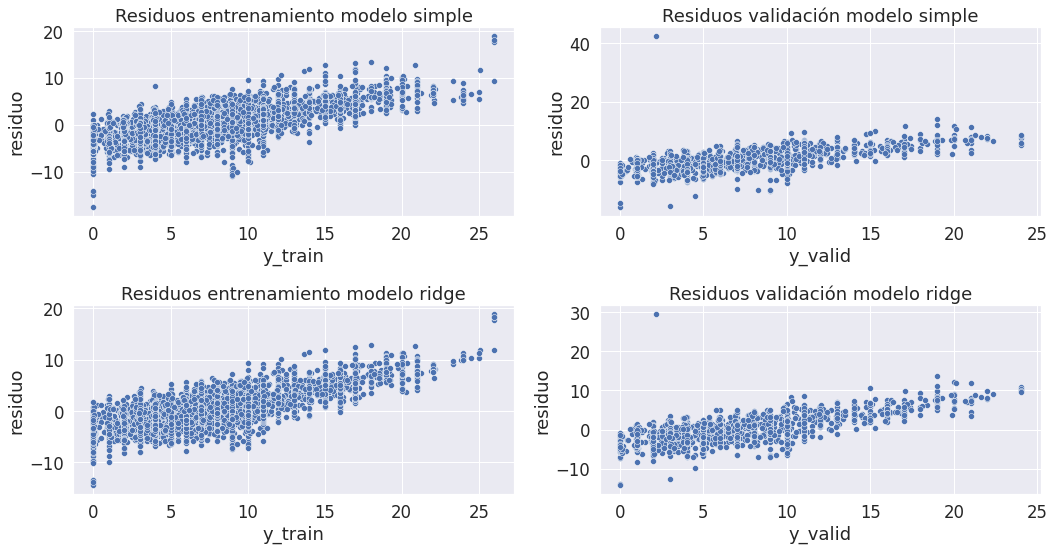

In [31]:
plt.figure(figsize=(15,8))
sns.set(font_scale = 1.5)
plt.subplot(2,2,1)
plt.title('Residuos entrenamiento modelo simple')
sns.scatterplot(y_train, res_train)
plt.xlabel('y_train')
plt.ylabel('residuo')
plt.subplot(2,2,2)
plt.title('Residuos validación modelo simple')
sns.scatterplot(y_valid, res_valid)
plt.xlabel('y_valid')
plt.ylabel('residuo')
plt.subplot(2,2,3)
plt.title('Residuos entrenamiento modelo ridge')
sns.scatterplot(y_train, res_train_ridge)
plt.xlabel('y_train')
plt.ylabel('residuo')
plt.subplot(2,2,4)
plt.title('Residuos validación modelo ridge')
sns.scatterplot(y_valid, res_valid_ridge)
plt.xlabel('y_valid')
plt.ylabel('residuo')
plt.tight_layout()

/home/andres/.local/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/andres/.local/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/andres/.local/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplo

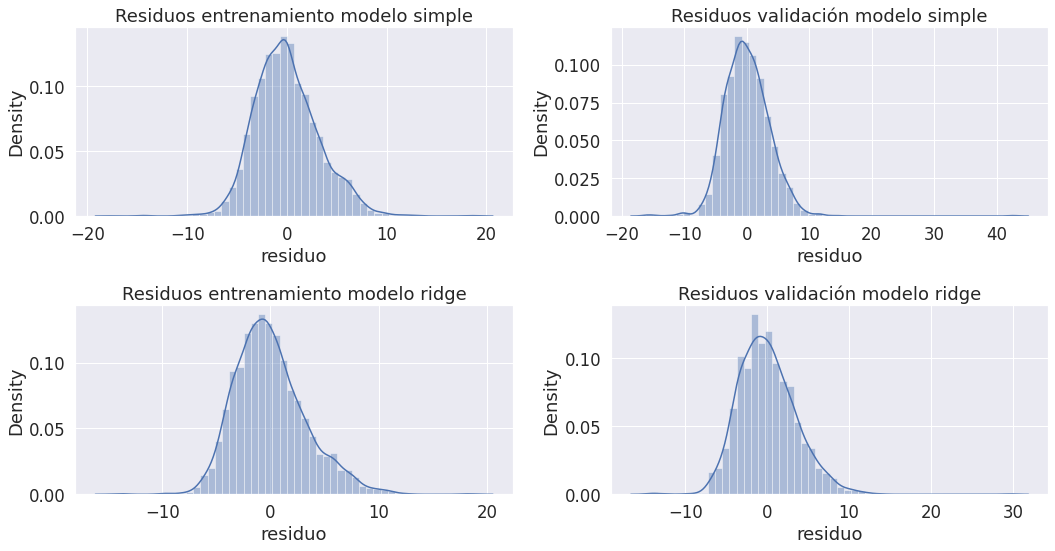

In [32]:
plt.figure(figsize=(15,8))
sns.set(font_scale = 1.5)
plt.subplot(2,2,1)
plt.title('Residuos entrenamiento modelo simple')
sns.distplot(res_train)
plt.xlabel('residuo')
plt.subplot(2,2,2)
plt.title('Residuos validación modelo simple')
sns.distplot(res_valid)
plt.xlabel('residuo')
plt.subplot(2,2,3)
plt.title('Residuos entrenamiento modelo ridge')
sns.distplot(res_train_ridge)
plt.xlabel('residuo')
plt.subplot(2,2,4)
plt.title('Residuos validación modelo ridge')
sns.distplot(res_valid_ridge)
plt.xlabel('residuo')
plt.tight_layout()

/home/andres/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/andres/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/andres/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/a

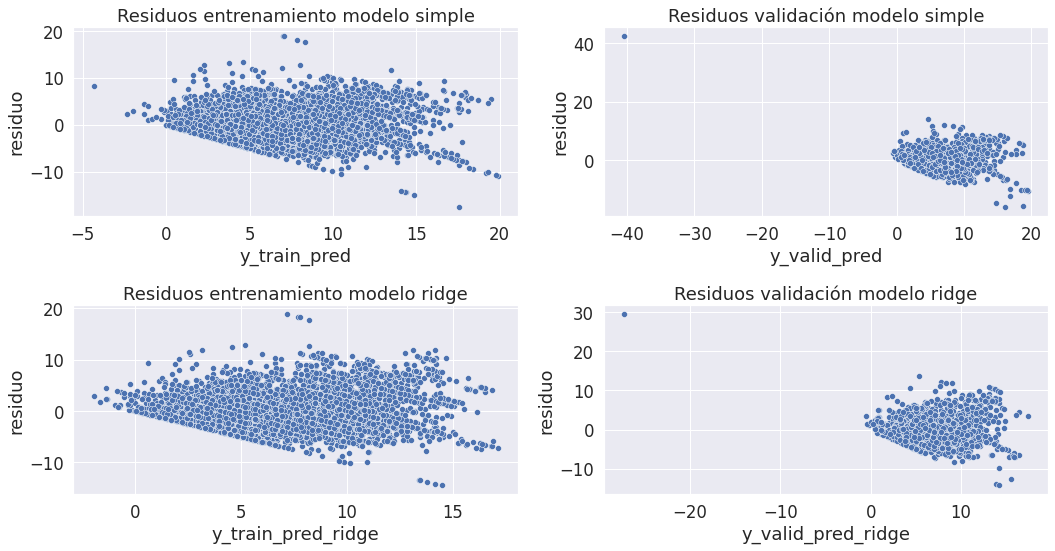

In [33]:
plt.figure(figsize=(15,8))
sns.set(font_scale = 1.5)
plt.subplot(2,2,1)
plt.title('Residuos entrenamiento modelo simple')
sns.scatterplot(y_train_pred, res_train)
plt.xlabel('y_train_pred')
plt.ylabel('residuo')
plt.subplot(2,2,2)
plt.title('Residuos validación modelo simple')
sns.scatterplot(y_valid_pred, res_valid)
plt.xlabel('y_valid_pred')
plt.ylabel('residuo')
plt.subplot(2,2,3)
plt.title('Residuos entrenamiento modelo ridge')
sns.scatterplot(y_train_pred_ridge, res_train_ridge)
plt.xlabel('y_train_pred_ridge')
plt.ylabel('residuo')
plt.subplot(2,2,4)
plt.title('Residuos validación modelo ridge')
sns.scatterplot(y_valid_pred_ridge, res_valid_ridge)
plt.xlabel('y_valid_pred_ridge')
plt.ylabel('residuo')
plt.tight_layout()

Finalmente el ultimo grafico que realizaremos es el QQ Plot, que nos indicara la distribucion del error a lo largo de los cuartiles.

**Genere un qq plot con las predicciones realizadas.**
(from statsmodels.graphics.gofplots import qqplot)


In [34]:
from statsmodels.graphics.gofplots import qqplot

En este caso los valores deben concentrarse sobre la linea diagonal.

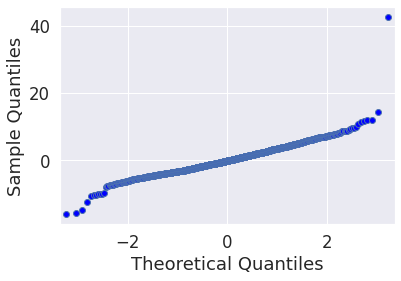

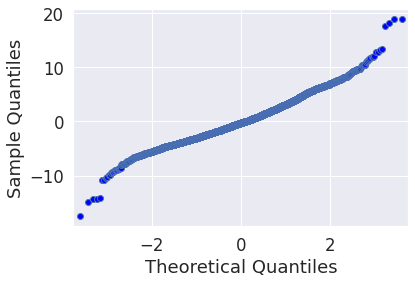

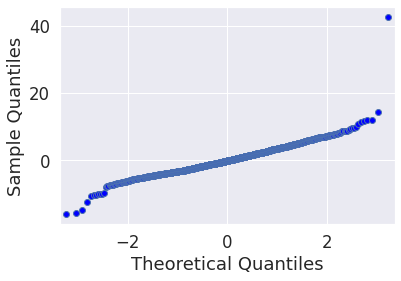

In [35]:
qqplot(res_train)
qqplot(res_valid)

#### Opcional:

La regularizacion es un metodo mediante el cual se penalisa el valor obsoluto de los coeficientes, de este modo se encuentran modelos mas estables y menos propensos a overfiear los datos.

Implemente una Regresion tipo Lasso (Regularizacion tipo L1) o tipo Ridge (Regularizacion tipo L2), calcula sus metricas y compare con la regresion lineal comun.

In [36]:
lineal_model_lasso = Lasso()
lineal_model_lasso.fit(X_train, y_train)
y_train_pred_lasso = lineal_model_lasso.predict(X_train)
y_valid_pred_lasso = lineal_model_lasso.predict(X_valid)

/home/andres/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 39108.4265791318, tolerance: 13.951874455893913
  model = cd_fast.enet_coordinate_descent(


In [37]:
print('Conjunto de entrenamiento: modelo lineal Lasso')
print('R2: ', r2_score(y_train,y_train_pred_lasso))
print('MAE: ', mean_absolute_error(y_train,y_train_pred_lasso))
print('MSE: ', mean_squared_error(y_train,y_train_pred_lasso))

print('Conjunto de validación: modelo lineal Lasso')
print('R2: ', r2_score(y_valid,y_valid_pred_lasso))
print('MAE: ', mean_absolute_error(y_valid,y_valid_pred_lasso))
print('MSE: ', mean_squared_error(y_valid,y_valid_pred_lasso))

Conjunto de entrenamiento: modelo lineal Lasso
R2:  0.45656369204930736
MAE:  2.626875740953355
MSE:  11.477376844236401
Conjunto de validación: modelo lineal Lasso
R2:  0.4370223477714046
MAE:  2.765527016295312
MSE:  12.290371157334672


## 5. Importancia de las variables, Regresion Lineal

En base a la arquitectura del modelo y utilizando los coeficientes del modelo, determine cuales son las 10 variables de mayor peso en el modelo y explique porque.

In [38]:
best_features_index = np.absolute(lineal_model_ridge.steps[1][1].coef_).argsort()[-20:][::1]
best_features = np.absolute(lineal_model_ridge.steps[1][1].coef_)[best_features_index]
best_features_names = untrd_limpio.iloc[:,best_features_index].columns

<AxesSubplot:>

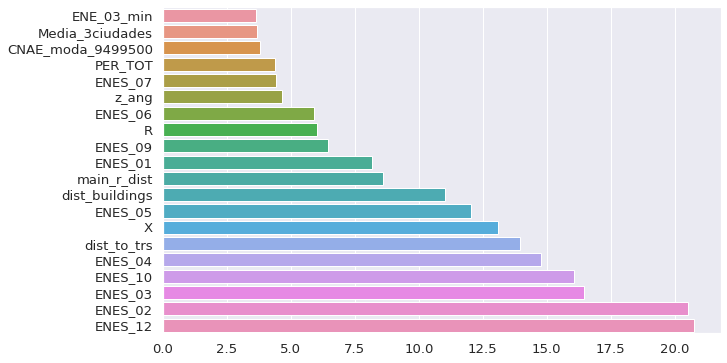

In [39]:
plt.figure(figsize=(10,6))
sns.set(font_scale = 1.2)
sns.barplot(y=best_features_names, x=best_features)

## 6. Preparacion de datos para algoritmos basados en arboles

Otra rama muy utilizada de modelos son aquellos basados en arboles de decision, como Bagging, Random Forrest o Boosting. En nuestro caso utilizaremos una implementacion de Boosting por gradiente denominada XGBoost que es reconocida por producir muy buenos resultados.

Dada la naturaleza de los arboles de decision en este caso es necesario normalizar los datos. Para demostrarlo, entrene dos modelos con parametros por default, utilizando el dataset normalizado y sin normalizar.

In [40]:
untrd_limpio.columns = untrd_limpio.columns.str.replace('[', '')
untrd_limpio.columns = untrd_limpio.columns.str.replace(']', '')
untrd_limpio.columns = untrd_limpio.columns.str.replace(' ', '_')

In [41]:
X_train, X_valid, y_train, y_valid = train_test_split(untrd_limpio, y, 
                                                      test_size=0.2, random_state=0)

In [42]:
import xgboost as xgb
data_dmatrix = xgb.DMatrix(data=untrd_limpio,label=y)

In [43]:
xg_reg = xgb.XGBRegressor()
xg_reg.fit(X_train,y_train);

In [44]:
y_train_pred_XGB = xg_reg.predict(X_train)
y_valid_pred_XGB = xg_reg.predict(X_valid)

In [45]:
print('Conjunto de entrenamiento: modelo XGBRegressor')
print('R2: ', r2_score(y_train,y_train_pred_XGB))
print('MAE: ', mean_absolute_error(y_train,y_train_pred_XGB))
print('MSE: ', mean_squared_error(y_train,y_train_pred_XGB))

print('Conjunto de validación: modelo XGBRegressor')
print('R2: ', r2_score(y_valid,y_valid_pred_XGB))
print('MAE: ', mean_absolute_error(y_valid,y_valid_pred_XGB))
print('MSE: ', mean_squared_error(y_valid,y_valid_pred_XGB))

Conjunto de entrenamiento: modelo XGBRegressor
R2:  0.975373979488741
MAE:  0.5311330254702186
MSE:  0.5201016447492481
Conjunto de validación: modelo XGBRegressor
R2:  0.790544722650728
MAE:  1.535932247716021
MSE:  4.572620403837535


In [45]:
1.485/y.mean()

0.20505341921473308

In [46]:
for proceso in procesos:
    xg_reg_norm = make_pipeline(proceso, xg_reg);
    xg_reg_norm.fit(X_train,y_train);
    y_train_pred_XGB_norm = xg_reg.predict(X_train.values)
    y_valid_pred_XGB_norm = xg_reg.predict(X_valid.values)
    print('R2: ', r2_score(y_train,y_train_pred_XGB_norm))
    print('MAE: ', mean_absolute_error(y_train,y_train_pred_XGB_norm))
    print('R2: ', r2_score(y_valid,y_valid_pred_XGB_norm))
    print('MAE: ', mean_absolute_error(y_valid,y_valid_pred_XGB_norm))

R2:  -0.25297000069584374
MAE:  4.249061469751381
R2:  -0.22723901076105135
MAE:  4.272180288069567
R2:  -1.4116273218949114
MAE:  6.353361849636041
R2:  -1.3006790835687623
MAE:  6.293437731400499
R2:  -0.2769347483537359
MAE:  4.334565056942233
R2:  -0.2582811808070409
MAE:  4.360662245385349
R2:  -1.060209266469462
MAE:  5.652929512077965
R2:  -0.9794944022879837
MAE:  5.62389353109042


In [47]:
y_train_pred_XGB_norm = xg_reg.predict(X_train.values)
y_valid_pred_XGB_norm = xg_reg.predict(X_valid.values)

In [48]:
print('Conjunto de entrenamiento: modelo XGBRegressor_norm')
print('R2: ', r2_score(y_train,y_train_pred_XGB_norm))
print('MAE: ', mean_absolute_error(y_train,y_train_pred_XGB_norm))
print('MSE: ', mean_squared_error(y_train,y_train_pred_XGB_norm))

print('Conjunto de validación: modelo XGBRegressor_norm')
print('R2: ', r2_score(y_valid,y_valid_pred_XGB_norm))
print('MAE: ', mean_absolute_error(y_valid,y_valid_pred_XGB_norm))
print('MSE: ', mean_squared_error(y_valid,y_valid_pred_XGB_norm))

Conjunto de entrenamiento: modelo XGBRegressor_norm
R2:  -1.060209266469462
MAE:  5.652929512077965
MSE:  43.51162736701668
Conjunto de validación: modelo XGBRegressor_norm
R2:  -0.9794944022879837
MAE:  5.62389353109042
MSE:  43.214363503912345


In [49]:
param_xgb = {
    'min_split_loss' : [0.1, 0.5, 0.75],
    'learning_rate' : [0.1, 0.5, 0.75],
    'min_child_weight' : [1,2,3,4,5,6],
    'max_depth' : [1,2,3,4,5],
    'lambda' : 10.0**-np.arange(-2,4),
    'n_estimators' : [1000]
}                           

In [50]:
cv_xgb = RandomizedSearchCV(xg_reg, param_xgb, scoring='r2', cv=5);
cv_xgb.fit(X_train,y_train);

In [51]:
best_model_xgb = cv_xgb.best_estimator_
y_train_pred_cv_xgb = best_model_xgb.predict(X_train)
y_valid_pred_cv_xgb = best_model_xgb.predict(X_valid)

In [52]:
best_model_xgb

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='', lambda=1.0,
             learning_rate=0.1, max_delta_step=0, max_depth=4,
             min_child_weight=2, min_split_loss=0.75, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=0,
             num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [53]:
print('Conjunto de entrenamiento: modelo XGBRegressor_cv')
print('R2: ', r2_score(y_train,y_train_pred_cv_xgb))
print('MAE: ', mean_absolute_error(y_train,y_train_pred_cv_xgb))
print('MSE: ', mean_squared_error(y_train,y_train_pred_cv_xgb))

print('Conjunto de validación: modelo XGBRegressor_cv')
print('R2: ', r2_score(y_valid,y_valid_pred_cv_xgb))
print('MAE: ', mean_absolute_error(y_valid,y_valid_pred_cv_xgb))
print('MSE: ', mean_squared_error(y_valid,y_valid_pred_cv_xgb))

Conjunto de entrenamiento: modelo XGBRegressor_cv
R2:  0.9678695543149114
MAE:  0.6037090015155241
MSE:  0.67859513231952
Conjunto de validación: modelo XGBRegressor_cv
R2:  0.7941560243482753
MAE:  1.5480784374401846
MSE:  4.493782037788243


In [54]:
y_train.shape, y_train_pred_cv_xgb.shape

((6606,), (6606,))

### Evaluacion del modelo, XGBoost

Seleccione uno de los modelos, calcule las metricas y realize el analisis un analisis de residuos, similar al realizado anteriormente.

In [55]:
res_train = y_train-y_train_pred_cv_xgb
res_valid = y_valid-y_valid_pred_cv_xgb

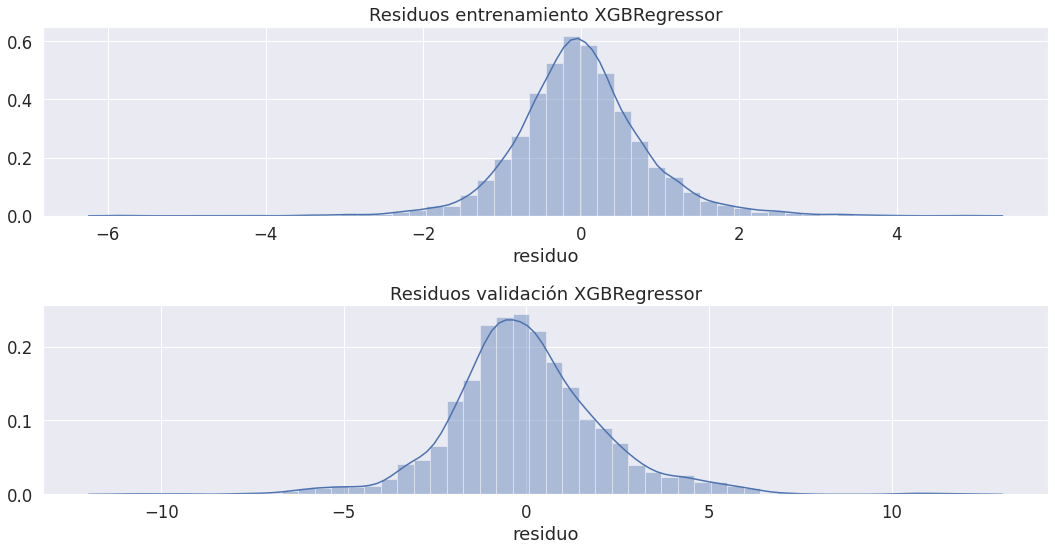

In [56]:
plt.figure(figsize=(15,8))
sns.set(font_scale = 1.5)
plt.subplot(2,1,1)
plt.title('Residuos entrenamiento XGBRegressor')
sns.distplot(res_train)
plt.xlabel('residuo')
plt.subplot(2,1,2)
plt.title('Residuos validación XGBRegressor')
sns.distplot(res_valid)
plt.xlabel('residuo')
plt.tight_layout()

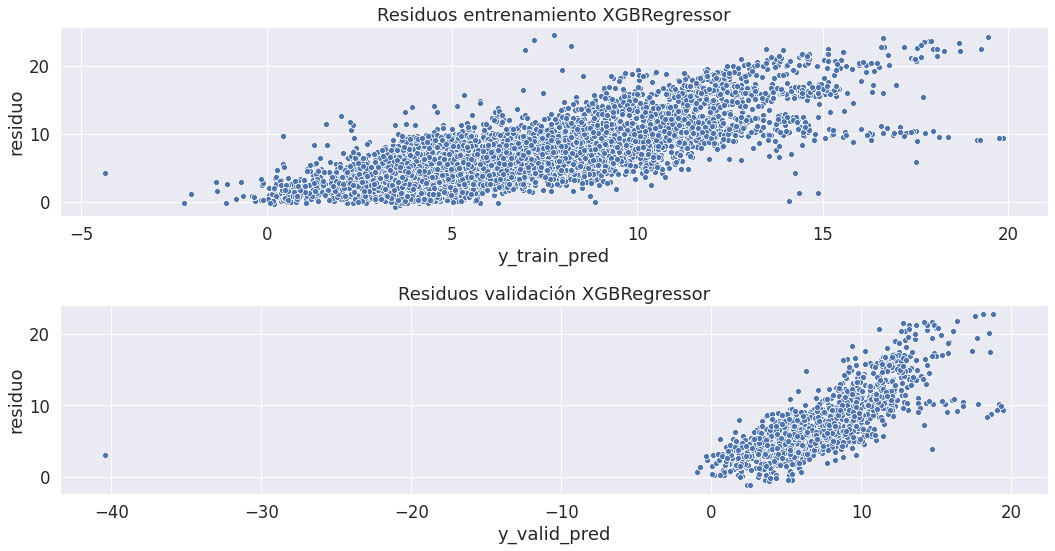

In [57]:
plt.figure(figsize=(15,8))
sns.set(font_scale = 1.5)
plt.subplot(2,1,1)
plt.title('Residuos entrenamiento XGBRegressor')
sns.scatterplot(y_train_pred, y_train_pred_cv_xgb)
plt.xlabel('y_train_pred')
plt.ylabel('residuo')
plt.subplot(2,1,2)
plt.title('Residuos validación XGBRegressor')
sns.scatterplot(y_valid_pred, y_valid_pred_cv_xgb)
plt.xlabel('y_valid_pred')
plt.ylabel('residuo')
plt.tight_layout()

## 7. Importancia de las variables

Utilize el metodo "Feature Importance" para determinar las 10 variables mas importante del modelo, verifique los diferentes criterios de calculo, seleccione uno y grafique sus coeficientes.

In [58]:
best_features_index = np.absolute(xg_reg.feature_importances_).argsort()[-20:][::1]
best_features = np.absolute(xg_reg.feature_importances_)[best_features_index]
best_features_names = untrd_limpio.iloc[:,best_features_index].columns

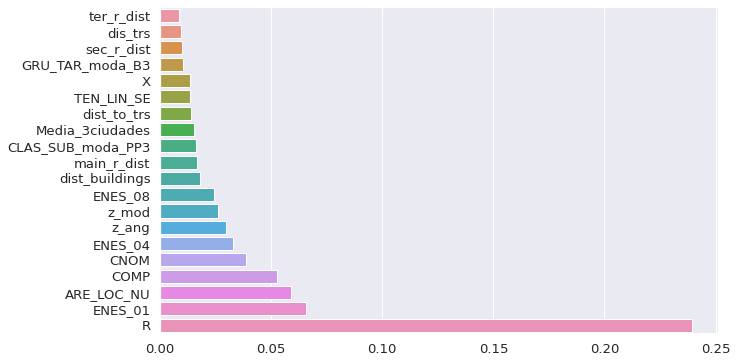

In [59]:
plt.figure(figsize=(10,6))
sns.set(font_scale = 1.2)
sns.barplot(y=best_features_names, x=best_features)

## 8. (Opcional) Conversion a problema de clasificacion

Podemos cambiar la naturaleza del problema de regresion a clasificacion simplemente cuantizando la salida y asignando una categoria cada intervalo.

Separe la salida en 5 intervalos segun su criterio, asignele categorias de 0 a 5, siendo 0 la peor calidad y 5 la mejor.

Entrene un classificador XGBoost, y calcule las metricas de accuracy, precision, recall, f1 score.

In [60]:
from sklearn.preprocessing import LabelEncoder

In [61]:
label_encoder = LabelEncoder()
n_bins = 6
y_cat = pd.Series(label_encoder.fit_transform(pd.cut(y, n_bins, retbins=True)[0]))

In [62]:
label_encoder.classes_

array([Interval(-0.026, 4.333, closed='right'),
       Interval(4.333, 8.667, closed='right'),
       Interval(8.667, 13.0, closed='right'),
       Interval(13.0, 17.333, closed='right'),
       Interval(17.333, 21.667, closed='right'),
       Interval(21.667, 26.0, closed='right')], dtype=object)

In [63]:
X_train, X_valid, y_train, y_valid = train_test_split(untrd_limpio, y_cat, 
                                                      test_size=0.2, random_state=0)

In [64]:
data_dmatrix_classifier = xgb.DMatrix(data=untrd_limpio,label=y_cat)

In [65]:
xg_clas = xgb.XGBClassifier()
xg_clas.fit(X_train,y_train);

In [66]:
y_train_pred = xg_clas.predict(X_train)

In [67]:
print(classification_report(y_train,y_train_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2082
           1       1.00      1.00      1.00      2287
           2       1.00      1.00      1.00      1544
           3       1.00      1.00      1.00       476
           4       1.00      1.00      1.00       182
           5       1.00      1.00      1.00        35

    accuracy                           1.00      6606
   macro avg       1.00      1.00      1.00      6606
weighted avg       1.00      1.00      1.00      6606



In [68]:
confusion_matrix(y_train,y_train_pred)

array([[2082,    0,    0,    0,    0,    0],
       [   1, 2286,    0,    0,    0,    0],
       [   0,    0, 1544,    0,    0,    0],
       [   0,    0,    0,  476,    0,    0],
       [   0,    0,    0,    0,  182,    0],
       [   0,    0,    0,    0,    0,   35]])

In [69]:
y_valid_pred = xg_clas.predict(X_valid)
print(classification_report(y_valid,y_valid_pred))

              precision    recall  f1-score   support

           0       0.81      0.81      0.81       526
           1       0.72      0.76      0.74       553
           2       0.79      0.73      0.76       391
           3       0.75      0.81      0.78       119
           4       0.81      0.56      0.66        52
           5       0.89      0.73      0.80        11

    accuracy                           0.77      1652
   macro avg       0.79      0.73      0.76      1652
weighted avg       0.77      0.77      0.77      1652



In [70]:
confusion_matrix(y_valid,y_valid_pred)

array([[427,  90,   9,   0,   0,   0],
       [ 81, 423,  45,   4,   0,   0],
       [ 16,  70, 286,  16,   3,   0],
       [  1,   5,  15,  96,   2,   0],
       [  2,   2,   6,  12,  29,   1],
       [  0,   0,   1,   0,   2,   8]])

## 9. Conclusiones

A partir de todos los puntos anteriores exponga sus impresiones y conclusiones personales.

1. En principio observamos que los modelos lineales no ajustan bien el conjunto de datos, con valores de R$^2$ alrededor de 0.5 en el caso del conjunto de entrenamiento y de 0.45 para el de test. Esta situación mejora si usamos una regularización l2 como es el caso del modelo Ridge y empeora drásticamente si empleamos cualquier método de normalización o estandarización de los datos. A su vez, para el MAE y MSE obtenemos valores entre 2.6-2.8 y 10.9-12.4 respectivamente para los conjuntos de entrenamiento y de test. El análisis de los residuos muestra que la distribución de esto es aproximadamente normal.

2. Cuando empleamos un modelo de ensamble utilizando la librería XGBoost, en particular el modelo de regresión pudimos ver que los valores de R$^2$, MAE y MSE se ubicaron alrededor de 0.98-0.81, 0.5-1.4 y 0.5-4.9 respectivamente para los conjuntos de entrenamiento y de test. En este caso cualquier tipo de preproceso desmejoró drásticamente los resultados. Finalmente realizamos una búsqueda al azar en el espacio de parámetros (10 modelos) con cross-fold validation que permitió mejorar los resultados obtenidos con el modelo por default. A su vez, se observa que la distribución de residuos es normal. Por otro lado, observamos que las variables más relevantes se cambian según el modelo pasando a ser la resitencia y el módulo de la impedancia las de mayor importancia para el modelo de ensable. Finalmente, implementamos un modelo de clasificación al agrupar la variable FIC en 6 categorías desde 0 hasta 5 siendo la mejor 0 y la peor 5. En este caso el valor de accuracy en el conjunto de entrenamiento dio 1 para todas las variables observándose una caída en el desempeño para el conjunto de test.

Podemos concluir que el modelo que mejor ajusta los datos es el XGBRegressor, podemos mejorar el modelo haciendo una búsqueda más fina ampliando la cantidad de modelos en el RandomizedSearchCV y utilizando los resultados para hacer GridSearchCV.